# **SVM Implementation**

## Installing and Importing Packages

The required packages are installed and imported.

In [74]:
#Installing packages

# !pip install matplotlib
# !pip install scikit-learn

In [75]:
#Importing packages
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Downloading Dataset

Downloading the dataset, retrieving its path and displaying the head and size.

In [76]:
#Downloading the dataset
path = kagglehub.dataset_download("willianoliveiragibin/healthcare-insurance")

In [77]:
#Retrieving the path to the dataset
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        path = os.path.join(dirname, filename)

In [78]:
#Displaying the first 5 rows of the dataset
df = pd.read_csv(path)
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Dataset Exploration

In [79]:
print("Dataset Row Count:", len(df))

Dataset Row Count: 1338


In [80]:
#General Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [81]:
# Unique values count in each column
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [82]:
# Smallest and largest charges
smallest_charge = df['charges'].min()
largest_charge = df['charges'].max()

print(f"Smallest charge: {smallest_charge}")
print(f"Largest charge: {largest_charge}")

Smallest charge: 1121.8739
Largest charge: 63770.42801


## Deciding Label to be Predicted

The ``charges`` attribute was decided to be the predicted value.

In [83]:
label = 'charges'

## Data Cleaning

Performing Data Cleaning techniques to prepare the dataset for model training.

**Removing Duplicate Rows**

In [84]:
#Removing duplicate rows
print("Dataset Size before Deduplication: ", len(df))
deDupDF = df.drop_duplicates(inplace=False)
print("Dataset Size after Deduplication: ", len(deDupDF))

Dataset Size before Deduplication:  1338
Dataset Size after Deduplication:  1337


**Removing Null Value Rows** 

In [85]:
#Removing rows with missing values
print("Dataset Size after Null Removal: ", len(deDupDF))
#Replacing all missing values with NaN
noNullDF = deDupDF.replace('?', np.nan, inplace=False)
#Dropping rows with any NaN values
noNullDF = noNullDF.dropna(inplace=False)
#Resetting index after dropping rows
noNullDF = noNullDF.reset_index(drop=True, inplace=False)
print("Dataset Size after Null Removal: ", len(noNullDF))

Dataset Size after Null Removal:  1337
Dataset Size after Null Removal:  1337


**Combining charges into Groups**

To avoid a regression problem the ``charges`` attribute was grouped into X groups, these being:

* **Very Low**: <= 5000
* **Low**: 5001 - 10000
* **Moderate**: 10001 - 15000
* **High**: 15001 - 20000
* **Very High**: > 20000  

In [86]:
binaryLabelDF = noNullDF.copy()

binaryLabelDF['charges'] = pd.cut(
    binaryLabelDF['charges'],
    bins=[-float('inf'), 5000, 10000, 15000, 20000, float('inf')],
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Visualising Percentage Splits
label_percentages = (binaryLabelDF['charges'].value_counts() / len(binaryLabelDF)) * 100
print(label_percentages)

# This is done to ensure that the mapping is correct
binaryLabelDF['charges'] = binaryLabelDF['charges'].map({'Very Low': 0, 'Low':1, 'Moderate':2, 'High':3, 'Very High':4})
binaryLabelDF.head(5)

charges
Very Low     26.776365
Low          26.402393
Very High    20.418848
Moderate     20.044877
High          6.357517
Name: count, dtype: float64


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,3
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,4
4,32,male,28.880,0,no,northwest,0


**Performing One-Hot Encoding**

This technique was required since the ``region`` attribute is a non-ordinal non-binary categorical classes.

The ``drop_first`` function drops one of the columns created from One-Hot Encoding to avoid the **Dummy Variable Trap**, which occurs when you have **Multicollinearity**. This phenomenon occurs when one of the new columns can be perfectly predicted by the others (i.e., if you know the values of n-1 columns, you can deduce the nth column). This can distort the model’s interpretation and lead to redundant information.

In [87]:
#Applying one-hot encoding to multiple categorical columns with drop_first to avoid the dummy variable trap
oHEDF = pd.get_dummies(binaryLabelDF, columns=['region'], drop_first=True)
print("Original Columns: ", df.columns)
print("New Columns: ", oHEDF.columns)
#Converting all columns to integer type
oHEDF.head(5)

Original Columns:  Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
New Columns:  Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,3,False,False,True
1,18,male,33.770,1,no,0,False,True,False
2,28,male,33.000,3,no,0,False,True,False
3,33,male,22.705,0,no,4,True,False,False
4,32,male,28.880,0,no,0,True,False,False


**Converting Binary Categorical Columns**

The ``sex`` and ``smoker`` columns are converted to integer values.

In [88]:
#Converting sex column to binary: Male -> 1, Female -> 0
binarySexDF = oHEDF.copy()
binarySexDF['sex'] = binarySexDF['sex'].map({'male': 1, 'female': 0})
#Checking the first few rows to confirm the conversion
binarySexDF.head(5)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,yes,3,False,False,True
1,18,1,33.770,1,no,0,False,True,False
2,28,1,33.000,3,no,0,False,True,False
3,33,1,22.705,0,no,4,True,False,False
4,32,1,28.880,0,no,0,True,False,False


In [89]:
#Converting sex column to binary: Male -> 1, Female -> 0
binarySmokerDF = binarySexDF.copy()
binarySmokerDF['smoker'] = binarySmokerDF['smoker'].map({'yes': 1, 'no': 0})
#Checking the first few rows to confirm the conversion
binarySmokerDF.head(5)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,3,False,False,True
1,18,1,33.770,1,0,0,False,True,False
2,28,1,33.000,3,0,0,False,True,False
3,33,1,22.705,0,0,4,True,False,False
4,32,1,28.880,0,0,0,True,False,False


In [90]:
binaryIntDF = binarySmokerDF.copy()

# Convert all columns except 'bmi' to integer type
columns_to_convert = binarySmokerDF.columns.difference(['bmi'])
binaryIntDF[columns_to_convert] = binarySmokerDF[columns_to_convert].astype(int)

# Checking the first few rows to confirm
binaryIntDF.head(5)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,3,0,0,1
1,18,1,33.770,1,0,0,0,1,0
2,28,1,33.000,3,0,0,0,1,0
3,33,1,22.705,0,0,4,1,0,0
4,32,1,28.880,0,0,0,1,0,0


**Applying log1p to Highly-Skewed Columns** 

**log1p** is performed to reduce skewness of columns. The main reason this is used is due to the way it handles 0 values safely. When performing this technique, One-Hot Encoding columns can be ignored, as skewness is relevant only to traditional continuous values. If a column's skewness factors is not between -1 and 1, it is considered to be highly-skewed, thus **log1p** is performed.

In [91]:
#Getting only continuous columns
continuous_columns = ['age', 'bmi']
continuousDF = binaryIntDF[continuous_columns]

#Calculating skewness for continuous columns
skewness = continuousDF.skew()

#Checking skewness of the data
print(skewness)

#Filtering columns where skewness > 1 or skewness < -1
high_skew_columns = skewness[skewness > 1].index.tolist() + skewness[skewness < -1].index.tolist()

print("\nColumns with skewness > 1 or < -1:", high_skew_columns)
#Applying log transformation to reduce skewness
reducedSkewDF = binaryIntDF.copy()
for column in high_skew_columns:
    reducedSkewDF[column] = np.log1p(reducedSkewDF[column])

#Checking the first few rows to confirm the transformation
reducedSkewDF.head(5)

age    0.054781
bmi    0.283914
dtype: float64

Columns with skewness > 1 or < -1: []


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,3,0,0,1
1,18,1,33.770,1,0,0,0,1,0
2,28,1,33.000,3,0,0,0,1,0
3,33,1,22.705,0,0,4,1,0,0
4,32,1,28.880,0,0,0,1,0,0


**Z-Score Normalisation**

This normalisation technique is used to rescale the data to have a **Mean of 0** and a **Standard Deviation of 1**. This is useful for models sensitive to feature scales, like SVMs, logistic regression, and k-means clustering.

In [92]:
#Initialising the scaler
scaler = StandardScaler()

#Creating a list of continuous columns to standardise
continuous_columns = ['age', 'bmi']

#Removing the label column from the list of continuous columns
continuous_columns = [col for col in continuous_columns if col != label]

#Applying standardisation
zNormalisedDF = reducedSkewDF.copy()
zNormalisedDF[continuous_columns] = scaler.fit_transform(zNormalisedDF[continuous_columns])

#Saving the scaler using pickle to be used for unseen data
scaler_name = 'z-score_scaler_svm_charges_classification'
with open('models/'+scaler_name+'.pkl', 'wb') as f:
    pickle.dump(scaler, f)

#Checking the first few rows to confirm the standardisation
zNormalisedDF.head(5)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,-1.440418,0,-0.453160,0,1,3,0,0,1
1,-1.511647,1,0.509422,1,0,0,0,1,0
2,-0.799350,1,0.383155,3,0,0,0,1,0
3,-0.443201,1,-1.305052,0,0,4,1,0,0
4,-0.514431,1,-0.292456,0,0,0,1,0,0


# SVM Setup & Training

In [93]:
# #Splitting features (X) and target (y)
# x = zNormalisedDF.drop(columns=[label]) 
# y = zNormalisedDF[label]

# #Splitting the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# #Initialising the SVM model and fitting it to the training data
# svm_model = SVC(kernel='linear')  
# svm_model.fit(X_train, y_train)

# #Predicting on the test set
# y_pred = svm_model.predict(X_test)

# #Evaluating the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred)) 

## One vs Many Approach

The One Vs Many approach is implemented, with Cross-Validation built-in as well as hyperparameter tuning. The best hyperparameters are selected and the resulting performance metrics are displayed. This model will also be tested on unseen examples.

In [ ]:
#Splitting the data into training and validation sets
X = zNormalisedDF.drop(columns=[label]) 
y = zNormalisedDF[label] 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Defining the parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10, 100], 
    'estimator__kernel': ['rbf', 'linear', 'poly'],  
    'estimator__gamma': ['scale', 'auto', 0.1, 0.01], 
    'estimator__degree': [3, 4, 5]  
}

#Initialising the OneVsOneClassifier with SVC as the base estimator
ovm_classifier = OneVsRestClassifier(SVC(probability=True))

#Defining SKFCV with 5 splits
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Initialising GridSearchCV
grid_search = GridSearchCV(estimator=ovm_classifier, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold, verbose=1, n_jobs=-1)

#Fitting the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

#Displaying the best model's hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Retrieving the best model
best_model = grid_search.best_estimator_

#Predicting on the validation set
y_pred = best_model.predict(X_val)

#Evaluating the model
print("Accuracy:", accuracy_score(y_val, y_pred))  
print("Classification Report:\n", classification_report(y_val, y_pred))  
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))  

#Saving the best model using pickle
model_name = 'best_health_svm_OvM_Charges_Classification'
with open('models/'+model_name+'.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## One vs One Approach

The One Vs One approach is implemented, with Cross-Validation built-in as well as hyperparameter tuning. The best hyperparameters are selected and the resulting performance metrics are displayed. This model will also be tested on unseen examples.

In [ ]:
#Splitting the data into training and validation sets
X = zNormalisedDF.drop(columns=[label]) 
y = zNormalisedDF[label]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Defining the parameter grid
param_grid = {
    'estimator__C': [10], #[0.1, 1, 10, 100], 
    'estimator__kernel': ['rbf'], #['rbf', 'linear', 'poly'],
    'estimator__gamma': [0.1], #['scale', 'auto', 0.1, 0.01],  
    'estimator__degree': [3] #[3, 4, 5]
}

#Defining SKFCV with 5 splits
ovo_classifier = OneVsOneClassifier(SVC(probability=True))

#Initialising the OneVsOneClassifier with SVC as the base estimator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Initialising GridSearchCV
grid_search = GridSearchCV(estimator=ovo_classifier, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold, verbose=1, n_jobs=-1)

#Fitting the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

#Displaying the best model's hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Retrieving the best model
best_model = grid_search.best_estimator_

#Predicting on the validation set
y_pred = best_model.predict(X_val)

#Evaluating the model
print("Accuracy:", accuracy_score(y_val, y_pred))  
print("Classification Report:\n", classification_report(y_val, y_pred))  
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))  

#Saving the best model using pickle
model_name = 'best_health_svm_OvO_Charges_Classification'
with open('models/'+model_name+'.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'estimator__C': 100, 'estimator__degree': 3, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Accuracy: 0.8917910447761194
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.90      0.94      0.92        70
           2       0.85      0.89      0.87        53
           3       0.75      0.46      0.57        13
           4       0.94      0.82      0.88        60

    accuracy                           0.89       268
   macro avg       0.87      0.82      0.83       268
weighted avg       0.89      0.89      0.89       268

Confusion Matrix:
 [[71  1  0  0  0]
 [ 2 66  2  0  0]
 [ 3  2 47  1  0]
 [ 2  1  1  6  3]
 [ 2  3  5  1 49]]


## ROC Curve (One Vs Many)

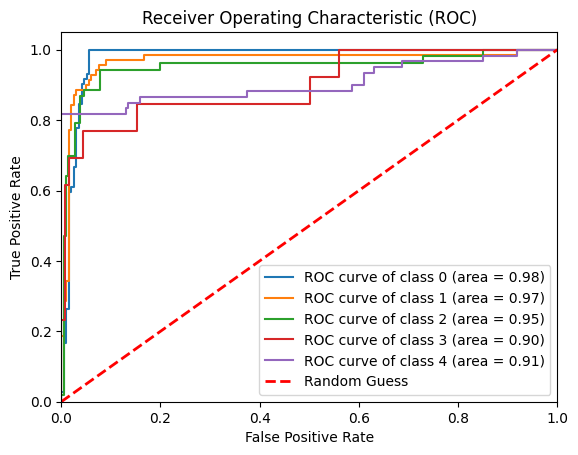

In [ ]:
# Load the model
with open('models/best_health_svm_OvM_Charges_Classification.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict probabilities for the validation set
y_prob = best_model.predict_proba(X_val)

# Get the number of classes
num_classes = len(np.unique(y_train))

# Initialize lists to store ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curves for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=2, label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve (One Vs Many)

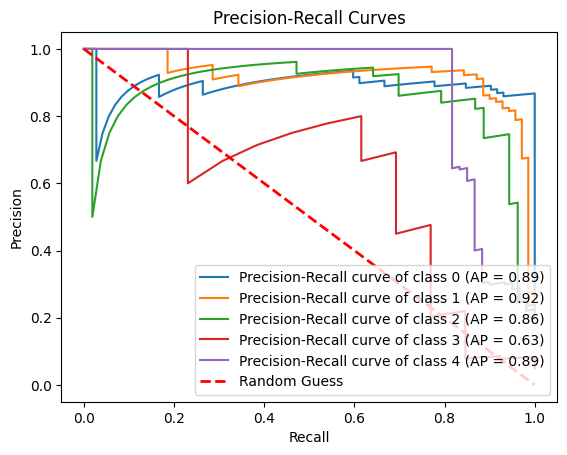

In [104]:
# Load the model
with open('models/best_health_svm_OvM_Charges_Classification.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict probabilities for the validation set
y_prob = best_model.predict_proba(X_val)

# Get the number of classes
num_classes = len(np.unique(y_train))

# Initialize lists to store Precision-Recall curves for each class
precision = dict()
recall = dict()
average_precision = dict()

# Calculate Precision-Recall curves for each class
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val == i, y_prob[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Calculate prior probability of each class
class_priors = np.bincount(y_train) / len(y_train)

# Plot Precision-Recall curves for each class
plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'
                                        ''.format(i, average_precision[i]))
    
# Plot the baseline (no skill)
plt.plot([0, 1], [1, 0], color="red", linestyle="--", lw=2, label="Random Guess")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")
plt.show()

# Processing Unseen Data

Now that the SVMs have been trained, the models can now be trained on custom data.

**Validating Data**

In [ ]:
#Defining the validation functions for each column 
def validate_age(value):
    #Checking if the value is an integer and within the specified range
    return isinstance(value, int) and 0 <= value <= 100

def validate_sex(value):
    #Checking if the value is in the specified list
    return value in ['Male', 'Female']

def validate_bmi(value):
    #Checking if the value is an integer and within the specified range
    return isinstance(value, float) and 0 <= value <= 60

def validate_childCount(value):
    #Checking if the value is an integer
    return isinstance(value, int)

def validate_isSmoker(value):
    #Checking if the value is in the specified list
    return value in ['Yes', 'No']

def validate_region(value):
    #Checking if the value is in the specified list
    return value in ['southwest', 'southeast', 'northwest', 'northeast']


#Defining function to validate the data
def validate_row(row, validation_functions):
    for col, value in row.items():
        if not validation_functions[col](value):
            return False  
    return True

#Defining function to append data if valid
def append_data(df, new_data, validation_functions):
    #Checking if new data is valid
    if validate_row(new_data, validation_functions):
        new_row_df = pd.DataFrame([new_data])
        #Appending the new data to the dataframe
        df = pd.concat([df, new_row_df], ignore_index=True)
        print("Data appended successfully!")
    else:
        print("Invalid data. Data was not appended.")
    return df

**Creating Unseen Example**

In [ ]:
#Defining the columns and data types as per the required format
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region'] # Features
#Defining the label column
label = 'charges' 

#Removing the label from the feature list and create an empty DataFrame with the specified columns
feature_list = [col for col in columns if col != label]
df = pd.DataFrame(columns=feature_list)

#Combining all validation functions in a dictionary
validation_functions = {
    'age': validate_age,
    'sex': validate_sex,
    'bmi': validate_bmi,
    'children': validate_childCount,
    'smoker': validate_isSmoker,
    'region': validate_region,
}

#Removing the validation function for the label from the dictionary
validation_functions.pop(label, None)

#Taking example from the training data where salary <=50K
new_data = {
    'age': 40,
    'sex': 'Male',
    'bmi': 30.3,
    'children': 0,
    'smoker': 'No',
    'region': 'southwest',
}

#Appending the data
df = append_data(df, new_data, validation_functions)

#Displaying the resulting DataFrame
display(df)

Data appended successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_27704\3500822193.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df], ignore_index=True)


,age,sex,bmi,children,smoker,region
0,40,Male,30.3,0,No,southwest


**Dropping Label Columns**

In [ ]:
#Creating a list of the columns present in dataframe used to train the model
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']

#Creating an empty DataFrame with these columns
formattedDF = pd.DataFrame(columns=columns)

#Dropping columns that contain the label in their name (These are not required as this will be what is predicted)
formattedDF = formattedDF.loc[:, ~formattedDF.columns.str.contains(label)]

print(formattedDF)

Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region_northwest, region_southeast, region_southwest]
Index: []


**Mapping the data from the input DF to the formattedDF**

In [ ]:
#Copying over the continuous columns
if label != 'age':
    formattedDF['age'] = df['age']
if label != 'sex':
    formattedDF['sex'] = formattedDF['sex'].apply(lambda x: 1 if x == 'Male' else 0)
if label != 'bmi':
    formattedDF['bmi'] = df['bmi']
if label != 'children':
    formattedDF['children'] = df['children']
if label != 'smoker':
    formattedDF['smoker'] = formattedDF['smoker'].apply(lambda x: 1 if x == 'Yes' else 0)
# if label != 'charges':
#     formattedDF['charges'] = df['charges']
if label != 'region':
    formattedDF['region_'+df['region']] = 1

#Filling in the remaining columns with 0 and converting to integer type
formattedDF.fillna(0, inplace=True)
formattedDF = formattedDF.astype(int)

#Keeping only the columns present in the training data (removing columns that were dropped during one-hot encoding due to drop_first = True)
formattedDF = formattedDF[formattedDF.columns.intersection(columns)]

#Displaying the formatted DataFrame
display(formattedDF)

C:\Users\User\AppData\Local\Temp\ipykernel_27704\3004092530.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  formattedDF.fillna(0, inplace=True)


,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,40,0,30,0,0,0,0,1


**Applying log1p to the skewed attributes identified during training**

In [ ]:
high_skew_columns = [] #No skewed columns detected during training

for column in high_skew_columns:
    formattedDF[column] = np.log1p(formattedDF[column])

**Applying the training scaler to the unseen data**

In [ ]:
#Loading the scaler and transform the data
# with open('models/z-score_scaler_svm_Education_Num_Classification.pkl', 'rb') as f:
with open('models/z-score_scaler_svm_charges_classification.pkl', 'rb') as f:
    scaler = pickle.load(f)

#Creating a list of continuous columns to standardize
continuous_columns = ['age', 'bmi']

#Applying the scaler to the unseen data
formattedDF[continuous_columns] = scaler.transform(formattedDF[continuous_columns])

formattedDF.head(5)

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,-1.440418,NaN,-0.453160,NaN,NaN,NaN,NaN,NaN
1,-1.511647,NaN,0.509422,NaN,NaN,NaN,NaN,NaN
2,-0.799350,NaN,0.383155,NaN,NaN,NaN,NaN,NaN
3,-0.443201,NaN,-1.305052,NaN,NaN,NaN,NaN,NaN
4,-0.514431,NaN,-0.292456,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Inverting the dict to map the 'charges' values back to 'charges' labels
inverse_mapping_charges = {
    0: 'Very Low (<= 5000)',
    1: 'Low (5001 - 10000)',
    2: 'Moderate (10001 - 15000)',
    3: 'High (15001 - 20000)',
    4: 'Very High (> 20001)',
}

**Make prediction on new data using Best Model**

In [ ]:
#Loading the saved model using pickle
with open('models/best_health_svm_OvM_Charges_Classification.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

#Making predictions with the loaded model
prediction = loaded_model.predict(formattedDF)

if label == 'charges':
    #Mapping the predicted values back to the original education values
    prediction = prediction[0]
    prediction = inverse_mapping_charges[prediction]
    predicted_label = 'charges'

#Displaying the predicted charges class
print("Predicted " + predicted_label + " Class:", prediction)

Predicted charges Class: Low (5001 - 10000)
